### Build Our Model

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset = pd.read_csv('archive/english.csv')
directory = "archive"

imageDatas = []
files = dataset["image"]
label = dataset["label"]
dimention = "100x100"
npzFileName = "Uncompressed_" + dimention + ".npz"

# Load  compressed image matrix data
data = np.load(npzFileName)
ImageData_compressed = data['imageDatas_np']
print("=======done load======")

print(ImageData_compressed.shape)

=======done load======
(3410, 100, 100, 1)


## Data Preprocessing
### 1) center the char

In [2]:
def centerChar(Img):
    dimension = len(Img)
    location = locatChar(Img)
    
    resultImg = []
    for i in range(dimension):
        row = []
        for j in range(dimension):
            row += [[np.float32(1.0)]]
            
        resultImg += [row]
    
    offset_row = int((dimension-(location[1] + 1 -location[0]))/2)    
    offset_col = int((dimension-(location[3] + 1 -location[2]))/2)
    
    for i in range(0, location[1] + 1 - location[0]):
        for j in range(0, location[3] + 1 - location[2]):
            resultImg[i + offset_row][j + offset_col][0] = Img[i + location[0]][j + location[2]][0]
    
    
    resultImg = np.array(resultImg)
    return resultImg
    
def locatChar(Img):
    dimension = len(Img)
    top = dimension
    bottom = 0
    left = dimension
    right = 0
    
    for i in range(dimension):
        for j in range(dimension):
            if Img[i][j][0] < 0.2:
                if top > i:
                    top = i
                if bottom < i:
                    bottom = i
                if left > j:
                    left = j
                if right < j:
                    right = j
    return [top, bottom, left, right]

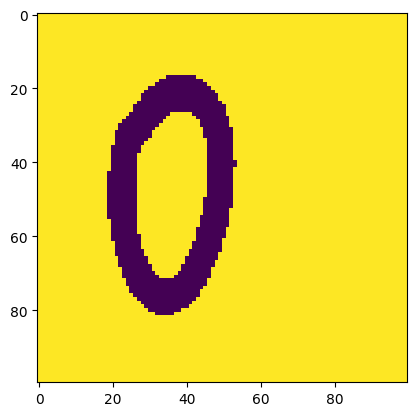

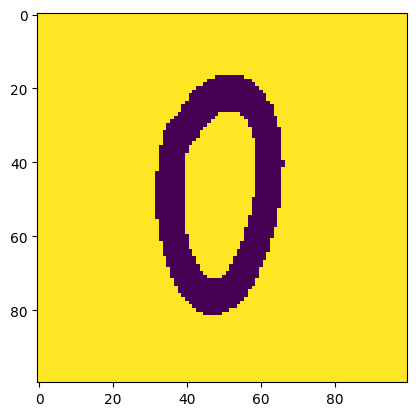

In [3]:
result = centerChar(ImageData_compressed[0])
plt.imshow(ImageData_compressed[0])
plt.show()
plt.imshow(result)
plt.show()

portion = (ImageData_compressed[0])[17:82, 19:54]
# plt.imshow(portion)
# plt.show()

In [7]:
# center all the data

ImageData_centered = []
count = 0
print("=====start processing=====")
for img in ImageData_compressed:
    img_c = centerChar(img)
    ImageData_centered += [img_c]
    
    count += 1
    if (count % 500 == 0):
        print("processed: ", count, " imgs" )

print("=====finish processing=====")

ImageData_centered = np.array(ImageData_centered)
print(ImageData_centered.shape)

=====start processing=====
processed:  500  imgs
processed:  1000  imgs
processed:  1500  imgs
processed:  2000  imgs
processed:  2500  imgs
processed:  3000  imgs
=====finish processing=====
(3410, 100, 100, 1)


In [8]:
import numpy
dimention = "100x100"
npzFileName = "Centered_" + dimention + ".npz"

# Save compressed data to NPZ file
# numpy.savez(npzFileName, ImageData_centered=ImageData_centered)
# print("=======done saving======")

=======done saving======


In [4]:
import numpy
import pandas as pd
import numpy as np

dataset = pd.read_csv('archive/english.csv')
directory = "archive"

imageDatas = []
files = dataset["image"]
label = dataset["label"]
dimention = "100x100"
npzFileName = "Centered_" + dimention + ".npz"

# Load  compressed image matrix data
data = numpy.load(npzFileName)
ImageData_centered = data['ImageData_centered']
print("=======done loading=======")

print(ImageData_centered.shape)

=======done loading=======
(3410, 100, 100, 1)


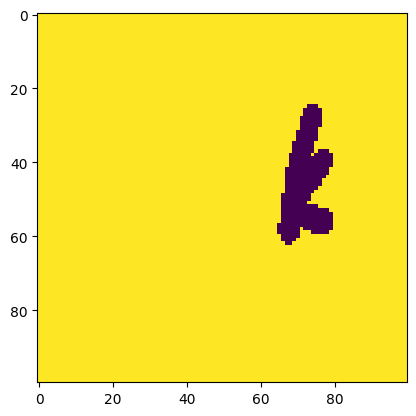

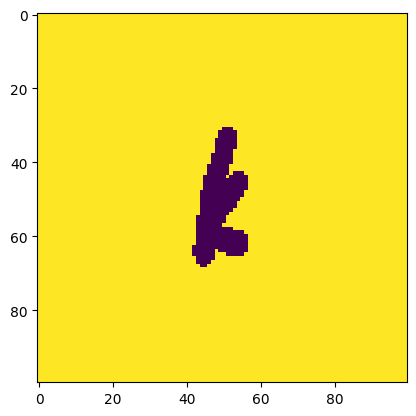

In [5]:
plt.imshow(ImageData_compressed[2578])
plt.show()
plt.imshow(ImageData_centered[2578])
plt.show()

In [8]:
def getIndex(letter):
    index = ord(letter)-48
    if (index > 10):
        index -= 7
    if (index > 35):
        index -= 6
    return index

In [9]:
from sklearn.model_selection import train_test_split

data_nparr=ImageData_centered
label_nparr=np.array(label)
label_index_nparr = np.vectorize(getIndex)(label_nparr)
label_index_onehot = pd.get_dummies(label_index_nparr) # one-hot encoded

train_data, test_data, train_label, test_label = train_test_split(data_nparr, label_index_onehot, test_size=0.1, random_state=11)
print("data splited")

data splited


In [22]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers

print("Input shape:", data_nparr[0].shape)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=data_nparr[0].shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(62, activation='softmax'))
print("Layers added")
model.summary()

Input shape: (100, 100, 1)
Layers added
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 flatten_3 (Fl

In [23]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("======start training======")
history = model.fit(train_data, train_label, epochs=4, 
                    validation_data=(test_data, test_label))
print("======done training======")

======start training======
Epoch 1/4
96/96 [==============================] - 14s 138ms/step - loss: 3.1558 - accuracy: 0.2268 - val_loss: 1.7632 - val_accuracy: 0.5103
Epoch 2/4
96/96 [==============================] - 14s 141ms/step - loss: 1.2542 - accuracy: 0.6468 - val_loss: 1.0181 - val_accuracy: 0.6716
Epoch 3/4
96/96 [==============================] - 14s 142ms/step - loss: 0.7216 - accuracy: 0.7761 - val_loss: 0.9022 - val_accuracy: 0.7595
Epoch 4/4
96/96 [==============================] - 14s 142ms/step - loss: 0.4822 - accuracy: 0.8413 - val_loss: 0.8392 - val_accuracy: 0.7566
======done training======


In [27]:

history = model.fit(train_data, train_label, epochs=1, 
                    validation_data=(test_data, test_label))

96/96 [==============================] - 14s 141ms/step - loss: 0.3327 - accuracy: 0.8873 - val_loss: 0.9299 - val_accuracy: 0.7331


In [10]:
# save model
# model.save('../CNN_ver6_ExtraDense_9-8.h5')
print("======model saved======")

======model saved======


11/11 - 0s - loss: 0.9299 - accuracy: 0.7331 - 294ms/epoch - 27ms/step


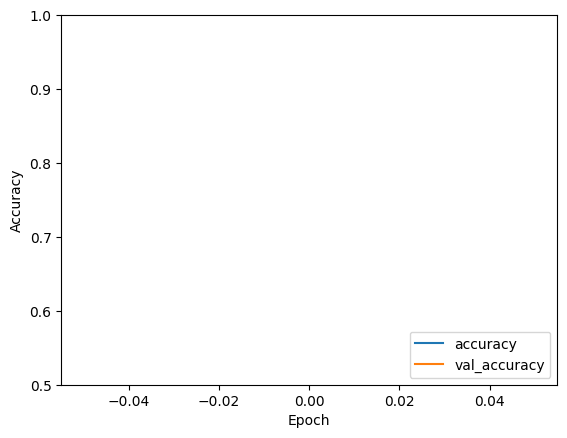

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_data,  test_label, verbose=2)

In [18]:
print(test_acc)

0.733137845993042


In [29]:
from sklearn.metrics import classification_report

# Function to convert one-hot encoded label to label index
def onehot_to_index(onehot_label):
    label_index = onehot_label.idxmax()  # Get the column name with the maximum value
    return label_index

# Function to convert one-hot encoded label to label index
def get_result(prob_array):
    return np.argmax(prob_array)

# Applying the function to each row of the DataFrame
label= test_label.apply(onehot_to_index, axis=1)

y_pred = model.predict(test_data)
y_pred_result = np.apply_along_axis(get_result, axis=1, arr=y_pred)


class_names = ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
class_names = class_names[0]

print(y_pred_result.shape)
print(classification_report(label, y_pred_result, target_names=class_names,  zero_division=1))

11/11 [==============================] - 0s 26ms/step
(341,)
              precision    recall  f1-score   support

           0       0.75      0.33      0.46         9
           1       0.75      0.75      0.75         4
           2       1.00      0.50      0.67         2
           3       1.00      0.88      0.93         8
           4       0.80      1.00      0.89         8
           5       0.67      0.40      0.50         5
           6       0.86      1.00      0.92         6
           7       1.00      1.00      1.00         6
           8       0.80      0.67      0.73         6
           9       0.60      0.50      0.55         6
           A       0.57      1.00      0.73         4
           B       0.75      0.75      0.75         4
           C       0.67      0.67      0.67         6
           D       0.89      0.73      0.80        11
           E       1.00      0.67      0.80         3
           F       0.75      1.00      0.86         3
           G       1

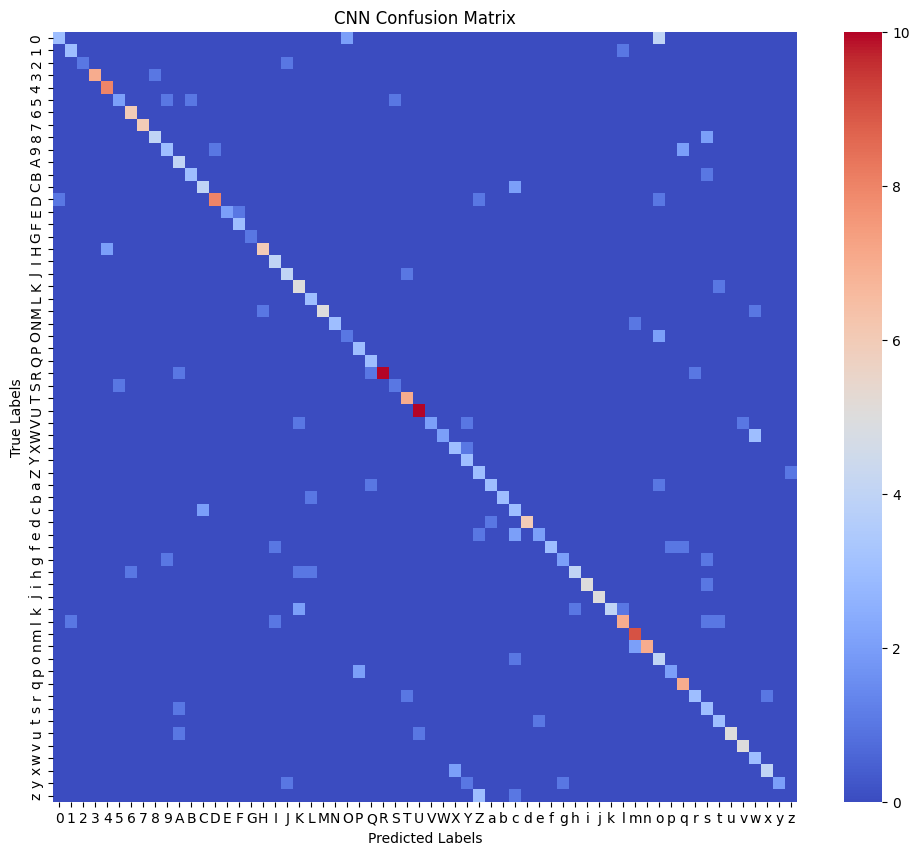

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(label, y_pred_result)


# Plot the confusion matrix as a heat map
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="coolwarm", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("CNN Confusion Matrix")
plt.show()